In [13]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import random
import os
import cv2
import shutil
import tqdm
import glob

In [14]:
# Check GPU is working or not
import torch
print(f"Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Using torch 2.4.0.dev20240420+cu118 (NVIDIA GeForce RTX 3060)


In [15]:
images_path = '../dataset/colorful_fashion_dataset_for_object_detection/JPEGImages/'
annotations_path  = '../dataset/colorful_fashion_dataset_for_object_detection/Annotations_txt/'
path = '../dataset/colorful_fashion_dataset_for_object_detection/'

# Try YoloV9

In [16]:
from ultralytics import YOLO

# load pre-trained model
detection_model = YOLO("yolov9c.pt")

In [17]:
# choose random image
img = random.choice(os.listdir(images_path))

i=detection_model.predict(source='https://i.stack.imgur.com/GRdCC.jpg', conf=0.5, save=True, line_thickness=2, hide_labels=False)

WARNING  'line_thickness' is deprecated and will be removed in 'ultralytics 8.399999999999999' in the future. Please use 'line_width' instead.
WARNING  'hide_labels' is deprecated and will be removed in 'ultralytics 8.399999999999999' in the future. Please use 'show_labels' instead.

Found https://i.stack.imgur.com/GRdCC.jpg locally at GRdCC.jpg
image 1/1 c:\Users\ADMIN\workspace\GitHub\Motocycle-Detection-BKAI\notebooks\GRdCC.jpg: 448x640 1 person, 1 bicycle, 4 cars, 3 trucks, 17.6ms
Speed: 1.0ms preprocess, 17.6ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs\detect\predict4


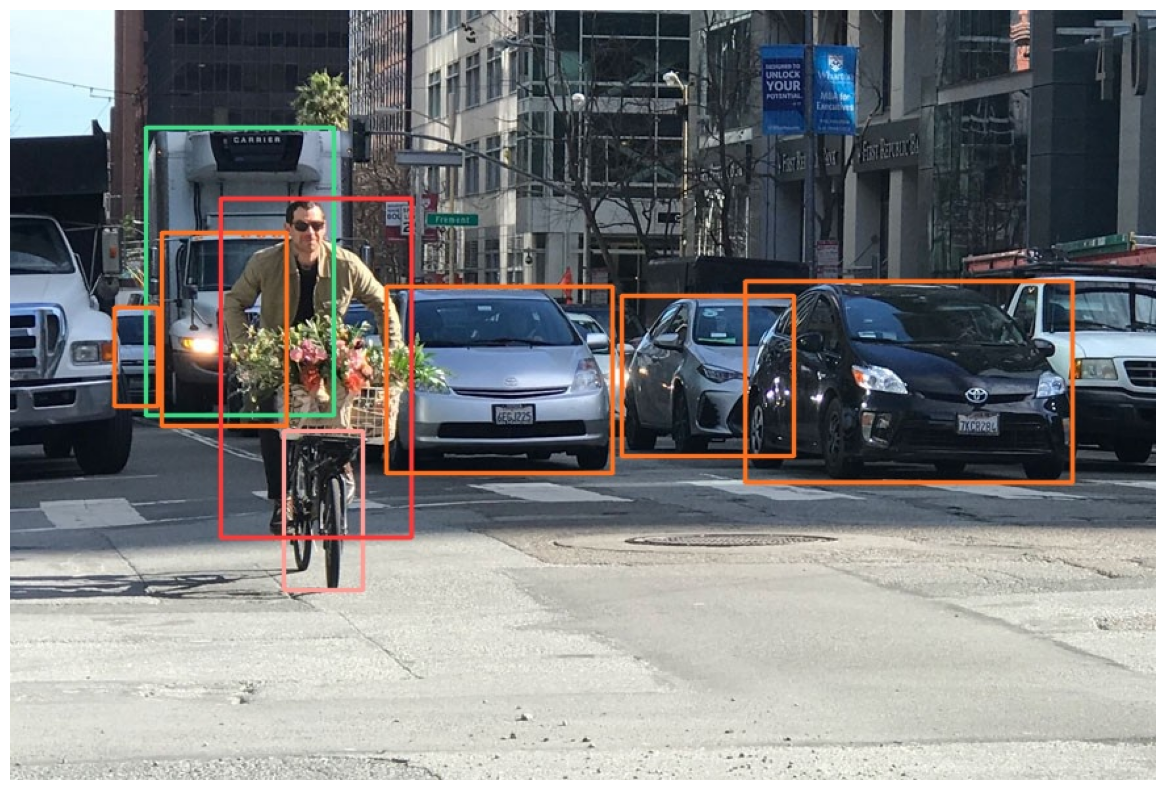

In [18]:
im = plt.imread('./runs/detect/predict/GRdCC.jpg')
plt.figure(figsize=(20,10))
plt.axis('off')
plt.imshow(im)

# Plot Training Data with Annotations

In [19]:
def convert(size,x,y,w,h):
    box = np.zeros(4)
    dw = 1./size[0]
    dh = 1./size[1]
    x = x/dw
    w = w/dw
    y = y/dh
    h = h/dh
    box[0] = x-(w/2.0)
    box[1] = x+(w/2.0)
    box[2] = y-(h/2.0)
    box[3] = y+(h/2.0)

    return (box)

def plot_annotations(img, filename):
    with open(annotations_path+filename, 'r') as f:
        for line in f:
            value = line.split()
            cls = int(value[0])
            x = float(value[1])
            y = float(value[2])
            w = float(value[3])
            h = float(value[4])
            
            img_h, img_w = img.shape[:2]
            bb = convert((img_w, img_h), x,y,w,h)
            cv2.rectangle(img, (int(round(bb[0])),int(round(bb[2]))),(int(round(bb[1])),int(round(bb[3]))),(255,0,0),2)
            plt.axis('off')
            plt.imshow(img)

# Prepare Dataset

In [20]:
train = []
with open(path+'ImageSets/Main/trainval.txt', 'r') as f:
    for line in f.readlines():
        if line[-1]=='\n':
            line = line[:-1]
        train.append(line)

test = []
with open(path+'ImageSets/Main/test.txt', 'r') as f:
    for line in f.readlines():
        if line[-1]=='\n':
            line = line[:-1]
        test.append(line)

In [21]:
len(train), len(test)

(2145, 537)

In [24]:
os.makedirs('train', exist_ok=True)
os.makedirs('train/images', exist_ok=True)
os.makedirs('train/labels', exist_ok=True)

os.makedirs('test', exist_ok=True)
os.makedirs('test/images', exist_ok=True)
os.makedirs('test/labels', exist_ok=True)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'train/images'

In [ ]:
train_path = 'train/'
test_path = 'test/'

print('Copying Train Data..!!')
for i in tqdm.tqdm(train):
    a = shutil.copyfile(images_path+i+'.jpg', train_path+'images/'+i+'.jpg')
    a = shutil.copyfile(annotations_path+i+'.txt', train_path+'labels/'+i+'.txt')

print('Copying Test Data..!!')
for i in tqdm.tqdm(test):
    a = shutil.copyfile(images_path+i+'.jpg', test_path+'images/'+i+'.jpg')
    a = shutil.copyfile(annotations_path+i+'.txt', test_path+'labels/'+i+'.txt')

Copying Train Data..!!


100%|██████████| 2145/2145 [00:18<00:00, 116.44it/s]


Copying Test Data..!!


100%|██████████| 537/537 [00:04<00:00, 108.28it/s]


# Train Custom Model

In [ ]:
text = """
train: /Users/ADMIN/workspace/GitHub/Motocycle-Detection-BKAI/notebooks/train
val: /Users/ADMIN/workspace/GitHub/Motocycle-Detection-BKAI/notebooks/test

# number of classes
nc: 10

# class names
names: ['sunglass','hat','jacket','shirt','pants','shorts','skirt','dress','bag','shoe']
"""
with open("data.yaml", 'w') as file:
    file.write(text)

In [ ]:
model = YOLO("yolov9c.pt")

model.train(data='data.yaml', epochs=50, batch=8)

Ultralytics YOLOv8.2.27  Python-3.10.14 torch-2.4.0.dev20240420+cu118 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
engine\trainer: task=detect, mode=train, model=yolov9c.pt, data=data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=T

100%|██████████| 755k/755k [00:01<00:00, 651kB/s] 


Overriding model.yaml nc=80 with nc=10

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  1    212864  ultralytics.nn.modules.block.RepNCSPELAN4    [128, 256, 128, 64, 1]        
  3                  -1  1    164352  ultralytics.nn.modules.block.ADown           [256, 256]                    
  4                  -1  1    847616  ultralytics.nn.modules.block.RepNCSPELAN4    [256, 512, 256, 128, 1]       
  5                  -1  1    656384  ultralytics.nn.modules.block.ADown           [512, 512]                    
  6                  -1  1   2857472  ultralytics.nn.modules.block.RepNCSPELAN4    [512, 512, 512, 256, 1]       
  7                  -1  1    656384  ultralytic

100%|██████████| 6.23M/6.23M [00:12<00:00, 532kB/s]


AMP: checks passed 


train: Scanning C:\Users\ADMIN\workspace\GitHub\Motocycle-Detection-BKAI\notebooks\train\labels... 2145 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2145/2145 [00:03<00:00, 604.26it/s]


train: New cache created: C:\Users\ADMIN\workspace\GitHub\Motocycle-Detection-BKAI\notebooks\train\labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning C:\Users\ADMIN\workspace\GitHub\Motocycle-Detection-BKAI\notebooks\test\labels... 537 images, 0 backgrounds, 0 corrupt: 100%|██████████| 537/537 [00:00<00:00, 560.20it/s]

val: New cache created: C:\Users\ADMIN\workspace\GitHub\Motocycle-Detection-BKAI\notebooks\test\labels.cache


Plotting labels to runs\detect\train3\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 154 weight(decay=0.0), 161 weight(decay=0.0005), 160 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train3
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      11.9G      1.439      2.715      1.615        110        640:  34%|███▍      | 46/135 [00:46<01:30,  1.02s/it]


KeyboardInterrupt: 